### ANÁLISE DE DESPESAS BRASIL - 2014 a 01/2025 

Nesse notebook vamos analisar as despesas do Brasil ao longo de 2014 até 01/2025, mas os dados podem ser aumentados a qualquer momento, bastando sua disponibilização no Portal da Transparência

Primeiramente, vamos abrir o arquivo com Spark para poder usufruir do seu paralelismo:

In [1]:
# Início do notebook

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, mean, stddev, when
from pyspark.storagelevel import StorageLevel
import pyspark.sql.functions as F

# Cria a sessão do Spark
spark = SparkSession.builder \
    .appName("AnaliseDespesasBrasil") \
    .master("local[4]") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.local.dir", "/tmp/spark-temp") \
    .config("spark.executor.extraJavaOptions", "-Duser.language=pt -Duser.country=BR") \
    .config("spark.driver.extraJavaOptions", "-Duser.language=pt -Duser.country=BR") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.driver.maxResultSize","2g") \
    .getOrCreate()

# Lê todos os arquivos CSV da pasta "data"
# Usamos opções para header e delimitador
#df = spark.read.options(header=True, delimiter=";", encoding="ISO-8859-1", inferSchema=False).csv("data/raw/*.csv")
parquet_path = "data/Despesas"
df = spark.read.parquet(parquet_path)

print("Schema do dataframe recriado a partir do Parquet:")


# Exibe o esquema para conferir os tipos
df.printSchema()
df.persist(StorageLevel.MEMORY_AND_DISK)
df.show()



25/02/22 15:16:24 WARN Utils: Your hostname, Lionheart.local resolves to a loopback address: 127.0.0.1; using 10.0.0.108 instead (on interface en0)
25/02/22 15:16:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/22 15:16:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/22 15:16:26 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Schema do dataframe recriado a partir do Parquet:
root
 |-- Ano e mês do lançamento: date (nullable = true)
 |-- Código Órgão Superior: integer (nullable = true)
 |-- Nome Órgão Superior: string (nullable = true)
 |-- Código Órgão Subordinado: integer (nullable = true)
 |-- Nome Órgão Subordinado: string (nullable = true)
 |-- Código Unidade Gestora: integer (nullable = true)
 |-- Nome Unidade Gestora: string (nullable = true)
 |-- Código Gestão: integer (nullable = true)
 |-- Nome Gestão: string (nullable = true)
 |-- Código Unidade Orçamentária: integer (nullable = true)
 |-- Nome Unidade Orçamentária: string (nullable = true)
 |-- Código Função: integer (nullable = true)
 |-- Nome Função: string (nullable = true)
 |-- Código Subfução: integer (nullable = true)
 |-- Nome Subfunção: string (nullable = true)
 |-- Código Programa Orçamentário: integer (nullable = true)
 |-- Nome Programa Orçamentário: string (nullable = true)
 |-- Código Ação: string (nullable = true)
 |-- Nome Ação: st

25/02/22 15:16:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------------+---------------------+--------------------+------------------------+----------------------+----------------------+--------------------+-------------+--------------------+---------------------------+-------------------------+-------------+-------------------+---------------+--------------------+----------------------------+--------------------------+-----------+--------------------+-------------------------+--------------------+-----------------------+---------------------+----+---------+----------------+--------------------+------------------+----------------+-----------------+----------------------------------+-------------------+--------------------+--------------------------+------------------------+-----------------------+---------------------+--------------------------+------------------------+----------------------------+---------------------+--------------------+--------------------+---------------+-----------------------------------+--------------------

Como não conhecemos bem os dados, vamos explorar algumas colunas, converter outras e procurar saber com que tipo de dados estamos lidando:

In [ ]:
#ENGENHARIA DOS DADOS (correções de tipos)
# Conversão dos valores monetários
#df = df.withColumn("Valor Empenhado (R$)", regexp_replace(col("Valor Empenhado (R$)"), ",", ".").cast("double")) \
#    .withColumn("Valor Liquidado (R$)", regexp_replace(col("Valor Liquidado (R$)"), ",", ".").cast("double")) \
##    .withColumn("Valor Pago (R$)", regexp_replace(col("Valor Pago (R$)"), ",", ".").cast("double")) \
#    .withColumn("Valor Restos a Pagar Inscritos (R$)", regexp_replace(col("Valor Restos a Pagar Inscritos (R$)"), ",", ".").cast("double")) \
#    .withColumn("Valor Restos a Pagar Cancelado (R$)", regexp_replace(col("Valor Restos a Pagar Cancelado (R$)"), ",", ".").cast("double")) \
#    .withColumn("Valor Restos a Pagar Pagos (R$)", regexp_replace(col("Valor Restos a Pagar Pagos (R$)"), ",", ".").cast("double"))

# Conversão para inteiro somente das colunas que já foram testadas e aprovadas
#int_columns = [
#    "Código Órgão Superior",
#    "Código Órgão Subordinado",
#    "Código Unidade Gestora",
#    "Código Gestão",
#    "Código Unidade Orçamentária",
#    "Código Função",
#    "Código Subfução",
#    "Código Programa Orçamentário",
#    "Código Localizador",
#    "Código Elemento de Despesa",
#    "Código Modalidade da Despesa",
#    "Código Autor Emenda"
#]

#for c in int_columns:
#    df = df.withColumn(c, col(c).cast("integer"))
#    print(f"A coluna {c} convertida para inteiro.")


A coluna Código Órgão Superior convertida para inteiro.
A coluna Código Órgão Subordinado convertida para inteiro.
A coluna Código Unidade Gestora convertida para inteiro.
A coluna Código Gestão convertida para inteiro.
A coluna Código Unidade Orçamentária convertida para inteiro.
A coluna Código Função convertida para inteiro.
A coluna Código Subfução convertida para inteiro.
A coluna Código Programa Orçamentário convertida para inteiro.
A coluna Código Localizador convertida para inteiro.
A coluna Código Elemento de Despesa convertida para inteiro.
A coluna Código Modalidade da Despesa convertida para inteiro.
A coluna Código Autor Emenda convertida para inteiro.


Aqui vamos converter o campo de data para um formato de date para permitir um melhor processamento dos dados

In [ ]:
#df = df.withColumn("Ano e mês do lançamento",
#                  F.to_date(F.concat(col("Ano e mês do lançamento"), F.lit("/01")), "yyyy/MM/dd"))


Essa célula usamos para exibir como está o nosso dataframe até o momento. Parece estar bem melhor o schema dele, mais bem estruturado

In [5]:
# Exibe o esquema e alguns registros para conferir
df.printSchema()
df.show()


root
 |-- Ano e mês do lançamento: date (nullable = true)
 |-- Código Órgão Superior: integer (nullable = true)
 |-- Nome Órgão Superior: string (nullable = true)
 |-- Código Órgão Subordinado: integer (nullable = true)
 |-- Nome Órgão Subordinado: string (nullable = true)
 |-- Código Unidade Gestora: integer (nullable = true)
 |-- Nome Unidade Gestora: string (nullable = true)
 |-- Código Gestão: integer (nullable = true)
 |-- Nome Gestão: string (nullable = true)
 |-- Código Unidade Orçamentária: integer (nullable = true)
 |-- Nome Unidade Orçamentária: string (nullable = true)
 |-- Código Função: integer (nullable = true)
 |-- Nome Função: string (nullable = true)
 |-- Código Subfução: integer (nullable = true)
 |-- Nome Subfunção: string (nullable = true)
 |-- Código Programa Orçamentário: integer (nullable = true)
 |-- Nome Programa Orçamentário: string (nullable = true)
 |-- Código Ação: string (nullable = true)
 |-- Nome Ação: string (nullable = true)
 |-- Código Plano Orçamentá

Vamos salvar esse dataframe agora para permitir que tenhamos um arquivo de dados mais enxuto e mais apropriado para a análise. Para passarmos a trabalhar com ele agora, permitindo maior velocidade e performance, vamos gravar e reabrir o dataframe a partir do novo arquivo

In [ ]:
import os
import glob

# Define os caminhos
csv_path_pattern = "data/raw/*.csv"
parquet_path = "data/Despesas"

# Salva o dataframe em parquet com compressão snappy
#df.write.mode("overwrite").option("compression", "snappy").parquet(parquet_path)

# Calcula o tamanho total dos arquivos CSV originais
csv_files = glob.glob(csv_path_pattern)
total_csv_size = sum(os.path.getsize(f) for f in csv_files)

# Calcula o tamanho total dos arquivos do parquet (o parquet é uma pasta com vários arquivos)
total_parquet_size = 0
for root, dirs, files in os.walk(parquet_path):
    for file in files:
        total_parquet_size += os.path.getsize(os.path.join(root, file))

print("Tamanho total dos CSVs (bytes):", total_csv_size)
print("Tamanho total do Parquet com snappy (bytes):", total_parquet_size)


Tamanho total dos CSVs (bytes): 7416331055
Tamanho total do Parquet com snappy (bytes): 450221117


In [3]:
# Exemplo: Cálculo de estatísticas globais para 'Valor_Empenhado'
stats = df.agg(
    mean("Valor Empenhado (R$)").alias("media_emp"),
    stddev("Valor Empenhado (R$)").alias("std_emp")
).collect()[0]

media_emp = stats["media_emp"]
std_emp = stats["std_emp"]

print("Média Valor Empenhado:", media_emp)
print("Desvio Padrão:", std_emp)

# Filtrando possíveis anomalias (usando 3 desvios-padrão como critério)
df_anomalias = df.filter(
    (col("Valor Empenhado (R$)") > media_emp + 3 * std_emp) | 
    (col("Valor Empenhado (R$)") < media_emp - 3 * std_emp)
)

print("Quantidade de registros anômalos (Valor Empenhado):", df_anomalias.count())

Média Valor Empenhado: 4306719.821669389
Desvio Padrão: 813476771.7336167


Quantidade de registros anômalos (Valor Empenhado): 1463


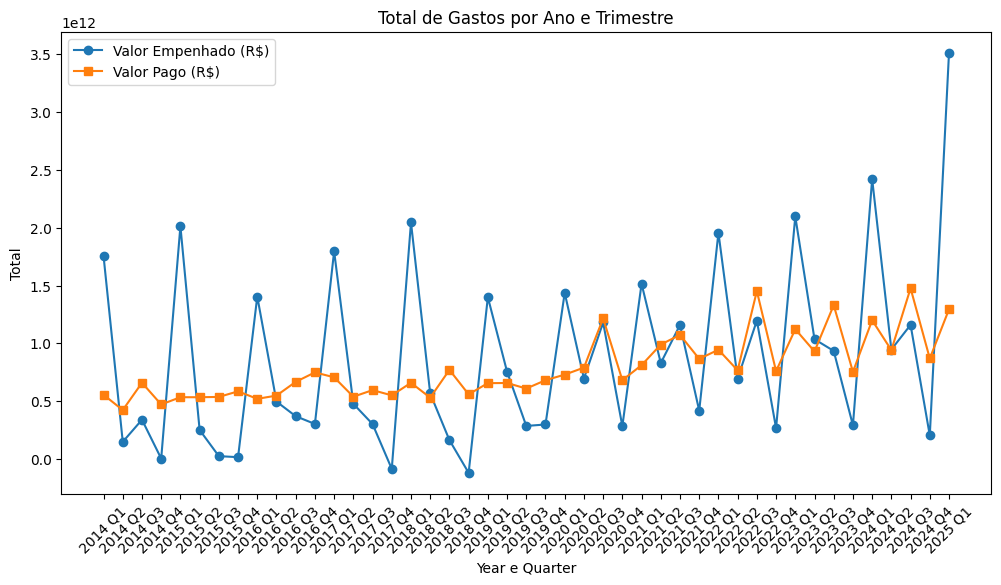

In [2]:
import pandas as pd
# Group data by date and compute the sum for both "Valor Empenhado (R$)" and "Valor Pago (R$)"
df_grouped = df.groupBy(
    F.year("Ano e mês do lançamento").alias("year"),
    F.quarter("Ano e mês do lançamento").alias("quarter")
).agg(
    F.sum("Valor Empenhado (R$)").alias("total_empenhado"),
    F.sum("Valor Pago (R$)").alias("total_pago")
).orderBy("year", "quarter")

# Convert the Spark DataFrame to a pandas DataFrame
df_grouped_pd = df_grouped.toPandas()
df_grouped_pd['year_quarter'] = df_grouped_pd['year'].astype(str) + " Q" + df_grouped_pd['quarter'].astype(str)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_grouped_pd['year_quarter'], df_grouped_pd['total_empenhado'], marker='o', label="Valor Empenhado (R$)")
plt.plot(df_grouped_pd['year_quarter'], df_grouped_pd['total_pago'], marker='s', label="Valor Pago (R$)")
plt.title("Total de Gastos por Ano e Trimestre")
plt.xlabel("Year e Quarter")
plt.ylabel("Total")
plt.xticks(rotation=45)


plt.legend()
plt.show()


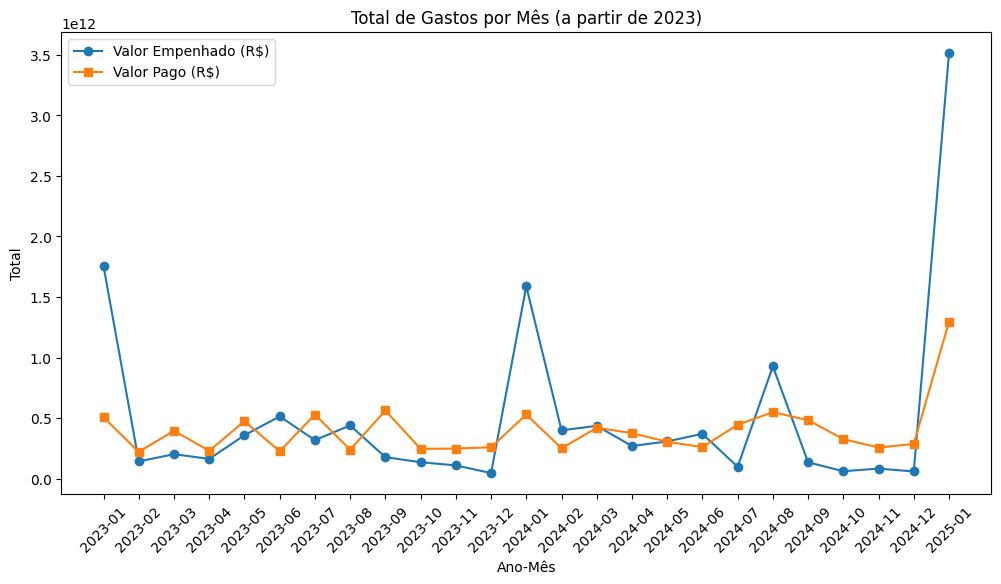

In [3]:
# Filtra apenas os registros a partir do ano de 2023 e cria uma coluna "year_month" no formato "yyyy-MM"
df_filtrado = df.filter(F.year("Ano e mês do lançamento") >= 2023) \
                .withColumn("year_month", F.date_format("Ano e mês do lançamento", "yyyy-MM"))

# Agrupa os dados por mês e calcula a soma dos valores empenhados e pagos
df_grouped_month = df_filtrado.groupBy("year_month").agg(
    F.sum("Valor Empenhado (R$)").alias("total_empenhado"),
    F.sum("Valor Pago (R$)").alias("total_pago")
).orderBy("year_month")

# Converte para pandas DataFrame para facilitar a plotagem
df_grouped_pd_month = df_grouped_month.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_grouped_pd_month['year_month'], df_grouped_pd_month['total_empenhado'], marker='o', label="Valor Empenhado (R$)")
plt.plot(df_grouped_pd_month['year_month'], df_grouped_pd_month['total_pago'], marker='s', label="Valor Pago (R$)")
plt.title("Total de Gastos por Mês (a partir de 2023)")
plt.xlabel("Ano-Mês")
plt.ylabel("Total")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [4]:
# Registra a tabela temporária para usar SQL
df.createOrReplaceTempView("despesas")

query = """
SELECT 
    year(`Ano e mês do lançamento`) AS ano,
    `Modalidade da Despesa`,
    format_number(sum(`Valor Empenhado (R$)`), 2) AS total_empenhado,
    format_number(sum(`Valor Pago (R$)`), 2) AS total_pago
FROM despesas
WHERE `Ano e mês do lançamento` BETWEEN '2023-01-01' AND '2025-01-31'
GROUP BY year(`Ano e mês do lançamento`), `Modalidade da Despesa`
ORDER BY ano, sum(`Valor Empenhado (R$)`) DESC, sum(`Valor Pago (R$)`) DESC
"""

df_sql = spark.sql(query)
df_sql.show(50)


+----+---------------------+--------------------+--------------------+
| ano|Modalidade da Despesa|     total_empenhado|          total_pago|
+----+---------------------+--------------------+--------------------+
|2023|   Aplicações Diretas|3,647,595,042,945.96|3,489,296,658,501.29|
|2023| Transferências a ...|  275,708,674,175.94|  257,022,436,152.30|
|2023| Transferências a ...|  265,286,038,643.95|  234,761,904,232.80|
|2023| Transferências a ...|   99,063,222,005.99|   92,730,589,427.71|
|2023| Transferências a ...|   32,768,396,306.55|   29,839,875,024.29|
|2023| Aplicação Direta ...|   21,868,652,222.92|   21,022,547,971.18|
|2023| Transferências a ...|   13,444,984,547.27|   10,166,728,587.35|
|2023| Transferências ao...|    2,646,505,507.10|    2,142,594,889.60|
|2023| Transferências Fu...|    1,643,246,526.00|    1,643,246,526.00|
|2023| Transferências Fu...|      927,580,000.00|      927,580,000.00|
|2023| Transferências a ...|      833,203,144.10|      531,427,196.03|
|2023|

In [13]:
import pandas as pd

# Converte o DataFrame Spark para pandas
df_sql_pd = df_sql.toPandas()

# Como os valores de 'total_empenhado' e 'total_pago' vêm formatados como strings, 
# vamos convertê-los para float para reformatá-los no padrão brasileiro.
df_sql_pd['total_empenhado'] = df_sql_pd['total_empenhado'].str.replace(',', '').astype(float)
df_sql_pd['total_pago'] = df_sql_pd['total_pago'].str.replace(',', '').astype(float)

# Função para formatar o número no padrão brasileiro: ponto com separador de milhar e vírgula como separador decimal
def format_brazil(value):
    # Formata com separador de milhar (,) e ponto como separador decimal, em seguida troca: 
    # - vírgula temporária para ponto
    # - ponto para vírgula
    # - ponto temporário para ponto
    return f"{value:,.2f}".replace(',', 'X').replace('.',',').replace('X','.')

# Aplica a formatação nas colunas numéricas
df_sql_pd['total_empenhado'] = df_sql_pd['total_empenhado'].apply(format_brazil)
df_sql_pd['total_pago'] = df_sql_pd['total_pago'].apply(format_brazil)

# Ajusta as opções de exibição do pandas para mostrar todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
display(df_sql_pd)


,ano,Modalidade da Despesa,total_empenhado,total_pago
0,2023,Aplicações Diretas,"3.647.595.042.945,96","3.489.296.658.501,29"
1,2023,Transferências a Estados e ao Distrito Federal,"275.708.674.175,94","257.022.436.152,30"
2,2023,Transferências a Municípios,"265.286.038.643,95","234.761.904.232,80"
3,2023,Transferências a Municípios - Fundo a Fundo,"99.063.222.005,99","92.730.589.427,71"
4,2023,Transferências a Estados e ao Distrito Federal - Fundo a Fundo,"32.768.396.306,55","29.839.875.024,29"
5,2023,"Aplicação Direta Decorrente de Operação entre Órgãos, Fundos e Entidades Integrantes dos Orçamentos Fis","21.868.652.222,92","21.022.547.971,18"
6,2023,Transferências a Instituições Privadas sem Fins Lucrativos,"13.444.984.547,27","10.166.728.587,35"
7,2023,Transferências ao Exterior,"2.646.505.507,10","2.142.594.889,60"
8,2023,Transferências Fundo a Fundo aos Municípios à conta de recursos de que tratam os §§ 1º e 2º do art. 24,"1.643.246.526,00","1.643.246.526,00"
9,2023,Transferências Fundo a Fundo aos Estados e ao Distrito Federal à conta de recursos de que tratam os §§ 1º,"927.580.000,00","927.580.000,00"


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

# Converte o DataFrame Spark para pandas (valor bruto, sem formatação, apenas anos a partir de 2023)
df_sample = df.filter((F.year("Ano e mês do lançamento") >= 2023) & (col("Valor Empenhado (R$)") > 0) & (col("Valor Pago (R$)") > 0))
pdf = df_sample.toPandas()


# Seleciona as features para o modelo
features = pdf[['Valor Empenhado (R$)', 'Valor Pago (R$)']]

# Cria e treina o modelo Isolation Forest
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(features)

# Utiliza o modelo para identificar anomalias (-1 para outliers, 1 para inliers)
pdf['anomaly'] = iso_forest.predict(features)


# Exibe a contagem de anomalias
anomaly_counts = pdf['anomaly'].value_counts()
print("Counts of anomalies (outliers vs inliers):")
print(anomaly_counts)   



Counts of anomalies (outliers vs inliers):
anomaly
 1    458354
-1     38353
Name: count, dtype: int64


In [8]:
# Exibe o DataFrame resultante com a coluna de anomalias
# Filtra as anomalias e ordena por "Valor Pago (R$)" em ordem decrescente
pdf_anomalies = pdf[pdf['anomaly'] == -1].sort_values(by='Valor Pago (R$)', ascending=False)

# Exibe o DataFrame resultante com as anomalias identificadas
display(pdf_anomalies)
#pdf_anomalies.to_excel("data/relatorios/anomalias.xlsx", index=False)


,Ano e mês do lançamento,Código Órgão Superior,Nome Órgão Superior,Código Órgão Subordinado,Nome Órgão Subordinado,Código Unidade Gestora,Nome Unidade Gestora,Código Gestão,Nome Gestão,Código Unidade Orçamentária,Nome Unidade Orçamentária,Código Função,Nome Função,Código Subfução,Nome Subfunção,Código Programa Orçamentário,Nome Programa Orçamentário,Código Ação,Nome Ação,Código Plano Orçamentário,Plano Orçamentário,Código Programa Governo,Nome Programa Governo,UF,Município,Código Subtítulo,Nome Subtítulo,Código Localizador,Nome Localizador,Sigla Localizador,Descrição Complementar Localizador,Código Autor Emenda,Nome Autor Emenda,Código Categoria Econômica,Nome Categoria Econômica,Código Grupo de Despesa,Nome Grupo de Despesa,Código Elemento de Despesa,Nome Elemento de Despesa,Código Modalidade da Despesa,Modalidade da Despesa,Valor Empenhado (R$),Valor Liquidado (R$),Valor Pago (R$),Valor Restos a Pagar Inscritos (R$),Valor Restos a Pagar Cancelado (R$),Valor Restos a Pagar Pagos (R$),anomaly
27051,2025-01-01,25000,Ministério da Fazenda,25000,Ministério da Fazenda - Unidades com vínculo d...,170600,COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA,1.0,TESOURO NACIONAL,75101,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,28,Encargos especiais,841,Refinanciamento da dívida interna,907,OPERACOES ESPECIAIS: REFINANCIAMENTO DA DIVIDA...,0365,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,0001,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,00,Sem informação,None,None,03650001,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIONAL,1,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIO,-1,Sem informação,NaN,SEM EMENDA,4,DESPESAS DE CAPITAL,6,Amortização/Refinanciamento da Dívida,76,Principal Corrigido da Dívida Mobiliária Re,90,Aplicações Diretas,8.550088e+11,6.881039e+11,6.881039e+11,0.0,0.0,0.00,-1
395048,2023-01-01,25000,Ministério da Fazenda,25000,Ministério da Fazenda - Unidades com vínculo d...,170600,COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA,1.0,TESOURO NACIONAL,75101,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,28,Encargos especiais,841,Refinanciamento da dívida interna,907,OPERACOES ESPECIAIS: REFINANCIAMENTO DA DIVIDA...,0365,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,0001,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,00,Sem informação,None,None,03650001,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIONAL,1,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIO,-1,Sem informação,NaN,SEM EMENDA,4,DESPESAS DE CAPITAL,6,Amortização/Refinanciamento da Dívida,76,Principal Corrigido da Dívida Mobiliária Re,90,Aplicações Diretas,5.600700e+11,4.197896e+11,4.197896e+11,0.0,0.0,0.00,-1
194568,2024-01-01,25000,Ministério da Fazenda,25000,Ministério da Fazenda - Unidades com vínculo d...,170600,COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA,1.0,TESOURO NACIONAL,75101,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,28,Encargos especiais,841,Refinanciamento da dívida interna,907,OPERACOES ESPECIAIS: REFINANCIAMENTO DA DIVIDA...,0365,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,0001,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,00,Sem informação,None,None,03650001,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIONAL,1,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIO,-1,Sem informação,NaN,SEM EMENDA,4,DESPESAS DE CAPITAL,6,Amortização/Refinanciamento da Dívida,76,Principal Corrigido da Dívida Mobiliária Re,90,Aplicações Diretas,3.920100e+11,3.714801e+11,3.714801e+11,0.0,0.0,0.00,-1
298345,2023-09-01,25000,Ministério da Fazenda,25000,Ministério da Fazenda - Unidades com vínculo d...,170600,COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA,1.0,TESOURO NACIONAL,75101,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,28,Encargos especiais,841,Refinanciamento da dívida interna,907,OPERACOES ESPECIAIS: REFINANCIAMENTO DA DIVIDA...,0365,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,0001,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,00,Sem informação,None,None,03650001,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIONAL,1,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIO,-1,Sem informação,NaN,SEM EMENDA,4,D

25/02/16 09:13:21 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 131483 ms exceeds timeout 120000 ms
25/02/16 09:13:21 WARN SparkContext: Killing executors is not supported by current scheduler.
25/02/16 09:13:21 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [ ]:
# Seleciona apenas as colunas que começam com "Nome"
nome_cols = [c for c in df.columns if c.startswith("Nome")]

# Define uma lista simples de stopwords em português
stopwords = [
    "a","as","à","às","o","os","e","é","de","da","do","das","dos","em","na","nas","no","nos",
    "um","uma","para","com","que","se","como","por","mas","mais","foi","ao","entre","sem",
    "sua","seu","só","também","está","este","esta","estão","há","já","vamos","pode","não"
]

# Concatena todas as colunas "Nome*" em letras minúsculas e remove pontuação
df_concat = df.select(
    F.lower(
        F.regexp_replace(
            F.concat_ws(" ", *[F.col(c) for c in nome_cols]),
            "[^\\p{L}\\p{Nd}\\s]+",""
        )
    ).alias("all_names")
)

# Divide em palavras e explode
df_words = df_concat.select(F.explode(F.split(F.col("all_names"), "\\s+")).alias("word"))

# Remove vazios e stopwords
df_filtered = df_words.filter(
    (F.col("word") != "") &
    (~F.col("word").isin(stopwords))
)

# Conta frequências, ordena, e exibe top 1000
df_top = (
    df_filtered.groupBy("word")
    .count()
    .orderBy(F.desc("count"))
    .limit(1000)
)


+------------------+--------+
|word              |count   |
+------------------+--------+
|nacional          |19314718|
|despesas          |16451826|
|informação        |15108753|
|correntes         |14463221|
|ministério        |10790939|
|defesa            |8368799 |
|emenda            |7820126 |
|outras            |7505472 |
|federal           |6484219 |
|educação          |4855411 |
|tesouro           |4436784 |
|administracao     |4089282 |
|gestao            |4072286 |
|unidade           |4027042 |
|manutencao        |3964962 |
|comando           |3632619 |
|universidade      |3577708 |
|educacao          |3483809 |
|programa          |3372380 |
|ministerio        |3098656 |
|profissional      |3008678 |
|ensino            |2993841 |
|serviços          |2975980 |
|funcionamento     |2971666 |
|instituto         |2956942 |
|aos               |2825185 |
|instituicoes      |2820284 |
|estado            |2732887 |
|outros            |2674562 |
|desenvolvimento   |2653017 |
|fundo    

In [3]:
df_top.show(3000, truncate=False)

+------------------+--------+
|word              |count   |
+------------------+--------+
|nacional          |19314718|
|despesas          |16451826|
|informação        |15108753|
|correntes         |14463221|
|ministério        |10790939|
|defesa            |8368799 |
|emenda            |7820126 |
|outras            |7505472 |
|federal           |6484219 |
|educação          |4855411 |
|tesouro           |4436784 |
|administracao     |4089282 |
|gestao            |4072286 |
|unidade           |4027042 |
|manutencao        |3964962 |
|comando           |3632619 |
|universidade      |3577708 |
|educacao          |3483809 |
|programa          |3372380 |
|ministerio        |3098656 |
|profissional      |3008678 |
|ensino            |2993841 |
|serviços          |2975980 |
|funcionamento     |2971666 |
|instituto         |2956942 |
|aos               |2825185 |
|instituicoes      |2820284 |
|estado            |2732887 |
|outros            |2674562 |
|desenvolvimento   |2653017 |
|fundo    

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import unicodedata
import re

# Função para remover acentos e cedilhas
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

# Define os campos de texto usados em todas as verificações de palavras-chave
text_fields = [
    'Descrição Complementar Localizador', 'Nome Órgão Superior', 'Nome Órgão Subordinado',
    'Nome Unidade Gestora', 'Nome Gestão', 'Nome Unidade Orçamentária', 'Nome Função',
    'Nome Subfunção', 'Nome Programa Orçamentário', 'Nome Ação', 'Nome Programa Governo',
    'Nome Subtítulo', 'Nome Localizador', 'Nome Autor Emenda', 'Nome Categoria Econômica',
    'Nome Grupo de Despesa', 'Nome Elemento de Despesa', 'Modalidade da Despesa'  
]

# Lista original de palavras-chave suspeitas (mantida sem remoções)
suspicious_keywords = [
    'corrupção', 'tráfico', 'crime', 'ilícito', 'criminalidade', 'organizado', 'violento',
    'despesas', 'terceiros', 'indenizações', 'ressarcimento',
    'manutenção', 'obras', 'construção', 'reforma', 'ampliação', 'equipamentos',
    'diárias', 'passagens', 'locomoção',
    'organização', 'fundação', 'internacional', 'multilaterais', 'bilaterais', 'embaixada', 'consuladogeral',
    'ambiental', 'sustentável', 'biodiversidade', 'mudança', 'equidade', 'inclusão',
    'emenda', 'bancada',
    'consultoria', 'prestação', 'serviços',
    'fome', 'desastres', 'emergência',
    'auxílio', 'benefícios', 'assistência',
    'transferências', 'contribuições', 'financiamento',
    'oscip', 'ong',
    'amazônia', 'pantanal', 'cerrado', 'caatinga', 'mata atlântica', 'pampa',
    'indígena', 'quilombola', 'comunidades tradicionais',
    'reforma agrária', 'agrícola', 'agricultura', 'pecuária', 'agropecuária',
    'segurança pública', 'polícia militar', 'prisional',
    'epidemia', 'pandemia', 'endemia', 'saúde sanitária', 'covid-19', 'coronavírus', 'sars-cov-2',
    'educação', 'escolar', 'universidade', 'aluno', 'estudante', 'professor', 'docente',
    'tecnologia da informação', 'comunicação', 'digital', 'internet', 'cibernética',
    'mídia', 'jornalismo', 'propaganda', 'publicidade',
    'cultura', 'artes', 'esporte', 'olimpíada', 'paralimpíada',
    'telecomunicações', 'telefonia', 'energia elétrica', 'petróleo', 'combustíveis',
    'mineração', 'indústria', 'industrialização',
    'oms', 'onu', 'fao', 'fmi', 'bid', 'bis', 'brics', 'g20', 'g7', 'g8', 'g77', 'gatt', 'mercosul',
    'ocde', 'omc', 'opep', 'otan', 'pnud', 'unesco', 'unicef',
    'banco mundial', 'banco interamericano de desenvolvimento', 'fundo monetário internacional',
    'organização das nações unidas',
    'floresta', 'banco', 'agência', 'saúde'
]

# Adiciona novas palavras-chave inspiradas na lista de termos frequentes
new_keywords = [
    'licitação', 'contrato', 'fornecedor', 'aquisição', 'contratação', 'pregão', 'dispensa', 'inexigibilidade',
    'emergencial', 'urgência', 'calamidade', 'eventos', 'campanha', 'capacitação', 'treinamento', 'software',
    'sistema', 'plataforma', 'reparos', 'conservação', 'reabilitação', 'investimentos', 'modernização',
    'infraestrutura', 'logística', 'assessoria', 'tecnológico', 'inovação', 'gestão', 'fiscalização'
]
suspicious_keywords.extend(new_keywords)

# Normaliza todas as palavras-chave suspeitas
normalized_keywords = [remove_accents(keyword.lower()) for keyword in suspicious_keywords]
keyword_pattern = re.compile(r'\b(' + '|'.join(re.escape(kw) for kw in normalized_keywords) + r')\b')

# Define categorias de palavras-chave para detecção mais inteligente
categories = {
    'high_risk': [
        'construção', 'obras', 'reforma', 'manutenção', 'infraestrutura', 'equipamentos', 'defesa', 'saúde',
        'educação', 'segurança pública', 'polícia militar', 'prisional', 'licitação', 'contrato', 'fornecedor',
        'aquisição', 'contratação', 'pregão', 'dispensa', 'inexigibilidade', 'investimentos', 'modernização',
        'logística', 'reparos', 'conservação', 'reabilitação'
    ],
    'vague': [
        'serviços', 'consultoria', 'assessoria', 'outros', 'despesas', 'terceiros', 'eventos', 'campanha',
        'capacitação', 'treinamento', 'software', 'sistema', 'plataforma', 'prestação', 'gestão'
    ],
    'political': [
        'emenda', 'bancada', 'parlamentar'
    ],
    'emergency': [
        'emergência', 'pandemia', 'desastre', 'fome', 'epidemia', 'endemia', 'covid-19', 'coronavírus',
        'sars-cov-2', 'emergencial', 'urgência', 'calamidade'
    ],
    'international': [
        'organização', 'fundação', 'internacional', 'multilaterais', 'bilaterais', 'embaixada', 'consuladogeral',
        'oms', 'onu', 'fao', 'fmi', 'bid', 'bis', 'brics', 'g20', 'g7', 'g8', 'g77', 'gatt', 'mercosul',
        'ocde', 'omc', 'opep', 'otan', 'pnud', 'unesco', 'unicef', 'banco mundial',
        'banco interamericano de desenvolvimento', 'fundo monetário internacional', 'organização das nações unidas'
    ],
    'social_program': [
        'auxílio', 'benefícios', 'assistência', 'transferências', 'contribuições', 'financiamento', 'oscip', 'ong',
        'indígena', 'quilombola', 'comunidades tradicionais', 'reforma agrária', 'agrícola', 'agricultura',
        'pecuária', 'agropecuária'
    ],
    'other_suspicious': [
        'corrupção', 'tráfico', 'crime', 'ilícito', 'criminalidade', 'organizado', 'violento', 'indenizações',
        'ressarcimento', 'diárias', 'passagens', 'locomoção', 'tecnologia da informação', 'comunicação', 'digital',
        'internet', 'cibernética', 'mídia', 'jornalismo', 'propaganda', 'publicidade', 'cultura', 'artes', 'esporte',
        'olimpíada', 'paralimpíada', 'telecomunicações', 'telefonia', 'energia elétrica', 'petróleo', 'combustíveis',
        'mineração', 'indústria', 'industrialização', 'floresta', 'banco', 'agência', 'fiscalização', 'tecnológico',
        'inovação'
    ]
}

# Compila padrões regex para cada categoria
patterns = {
    cat: re.compile(r'\b(' + '|'.join(re.escape(remove_accents(kw.lower())) for kw in keywords) + r')\b')
    for cat, keywords in categories.items()
}

# Função genérica para verificar presença de palavras-chave
def contains_keyword(text, pattern):
    return 1 if pattern.search(text) else 0

# Função para verificar palavras-chave suspeitas (mantida do código original)
def contains_suspicious_keyword(row):
    text = ' '.join([str(row[field]) for field in text_fields if field in row]).lower()
    text = remove_accents(text)
    return 1 if keyword_pattern.search(text) else 0

# Filtra os dados para anos >= 2023 e valores positivos
df_sample = df.filter((F.year("Ano e mês do lançamento") >= 2023) & 
                      (col("Valor Empenhado (R$)") > 0) & 
                      (col("Valor Pago (R$)") > 0))

# Converte para DataFrame do pandas
pdf = df_sample.toPandas()

# Converte a coluna de data para datetime
pdf['Ano e mês do lançamento'] = pd.to_datetime(pdf['Ano e mês do lançamento'], errors='coerce')

# Cria coluna de texto concatenado e normalizado para otimizar a detecção
pdf['text'] = pdf[text_fields].astype(str).agg(' '.join, axis=1).str.lower().apply(remove_accents)

# Cria features binárias
pdf['is_emenda'] = pdf['Nome Autor Emenda'].apply(lambda x: 0 if x == 'SEM EMENDA' else 1)
pdf['contains_suspicious_keyword'] = pdf.apply(contains_suspicious_keyword, axis=1)

# Adiciona features binárias por categoria
for cat in categories:
    pdf[f'contains_{cat}_keyword'] = pdf['text'].apply(lambda x: contains_keyword(x, patterns[cat]))

# Cria features numéricas
pdf['paid_to_committed'] = pdf['Valor Pago (R$)'] / pdf['Valor Empenhado (R$)']
pdf['paid_minus_committed'] = pdf['Valor Pago (R$)'] - pdf['Valor Empenhado (R$)']

# Extrai features de data
pdf['year'] = pdf['Ano e mês do lançamento'].dt.year
pdf['month'] = pdf['Ano e mês do lançamento'].dt.month

# Lista de colunas categóricas para codificação de frequência
categorical_cols = [
    'Código Órgão Superior', 'Código Programa Orçamentário', 'UF',
    'Código Categoria Econômica', 'Código Grupo de Despesa',
    'Código Elemento de Despesa', 'Código Modalidade da Despesa'
]

# Codificação de frequência para colunas categóricas
for col in categorical_cols:
    freq = pdf[col].value_counts(normalize=True)
    pdf[col + '_freq'] = pdf[col].map(freq)

# Seleciona features para o modelo, incluindo a feature original e as novas por categoria
keyword_features = [f'contains_{cat}_keyword' for cat in categories]
features = [
    'Valor Empenhado (R$)', 'Valor Liquidado (R$)', 'Valor Pago (R$)',
    'paid_to_committed', 'paid_minus_committed', 'year', 'month',
    'is_emenda', 'contains_suspicious_keyword'
] + keyword_features + [col + '_freq' for col in categorical_cols]

# Trata valores ausentes
for col in features:
    if pdf[col].dtype in ['float64', 'int64']:
        pdf[col] = pdf[col].fillna(pdf[col].median())
    else:
        pdf[col] = pdf[col].fillna(0)

# Treina o Isolation Forest no conjunto completo com contamination muito baixa
iso_forest = IsolationForest(random_state=42, contamination=0.2)  #  20% como anomalias
iso_forest.fit(pdf[features])

# Prediz anomalias no conjunto completo
pdf['anomaly_pred'] = iso_forest.predict(pdf[features])

# Separa os três DataFrames de anomalias
anomalias_emendas = pdf[(pdf['anomaly_pred'] == -1) & (pdf['is_emenda'] == 1)]
anomalias_desgoverno = pdf[(pdf['anomaly_pred'] == -1) & (pdf['is_emenda'] == 0)]

# Treina um modelo separado para transações sem emenda
pdf_non_emenda = pdf[pdf['is_emenda'] == 0].copy()
features_non_emenda = [feat for feat in features if feat != 'is_emenda']
iso_forest_non_emenda = IsolationForest(random_state=42, contamination=0.2)
iso_forest_non_emenda.fit(pdf_non_emenda[features_non_emenda])
pdf_non_emenda['anomaly_desgoverno'] = iso_forest_non_emenda.predict(pdf_non_emenda[features_non_emenda])
anomalias_desgoverno_refined = pdf_non_emenda[pdf_non_emenda['anomaly_desgoverno'] == -1]

# Salva os DataFrames em arquivos Excel
anomalias_emendas.to_excel('data/relatorios/anomalias_emendas.xlsx', index=False, engine='openpyxl')
anomalias_desgoverno.to_excel('data/relatorios/anomalias_desgoverno.xlsx', index=False, engine='openpyxl')
anomalias_desgoverno_refined.to_excel('data/relatorios/anomalias_desgoverno_refined.xlsx', index=False, engine='openpyxl')

# Mensagem de confirmação
print("Arquivos salvos com sucesso:")
print("- data/relatorios/anomalias_emendas.xlsx")
print("- data/relatorios/anomalias_desgoverno.xlsx")
print("- data/relatorios/anomalias_desgoverno_refined.xlsx")

Arquivos salvos com sucesso:
- data/relatorios/anomalias_emendas.xlsx
- data/relatorios/anomalias_desgoverno.xlsx
- data/relatorios/anomalias_desgoverno_refined.xlsx


In [15]:


# Exibir todas as colunas e as primeiras 1000 linhas do dataframe pdf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
display(anomalias_desgoverno_refined.head(1000))


,Ano e mês do lançamento,Código Órgão Superior,Nome Órgão Superior,Código Órgão Subordinado,Nome Órgão Subordinado,Código Unidade Gestora,Nome Unidade Gestora,Código Gestão,Nome Gestão,Código Unidade Orçamentária,Nome Unidade Orçamentária,Código Função,Nome Função,Código Subfução,Nome Subfunção,Código Programa Orçamentário,Nome Programa Orçamentário,Código Ação,Nome Ação,Código Plano Orçamentário,Plano Orçamentário,Código Programa Governo,Nome Programa Governo,UF,Município,Código Subtítulo,Nome Subtítulo,Código Localizador,Nome Localizador,Sigla Localizador,Descrição Complementar Localizador,Código Autor Emenda,Nome Autor Emenda,Código Categoria Econômica,Nome Categoria Econômica,Código Grupo de Despesa,Nome Grupo de Despesa,Código Elemento de Despesa,Nome Elemento de Despesa,Código Modalidade da Despesa,Modalidade da Despesa,Valor Empenhado (R$),Valor Liquidado (R$),Valor Pago (R$),Valor Restos a Pagar Inscritos (R$),Valor Restos a Pagar Cancelado (R$),Valor Restos a Pagar Pagos (R$),is_emenda,contains_suspicious_keyword,paid_to_committed,paid_minus_committed,year,month,Código Órgão Superior_freq,Código Programa Orçamentário_freq,UF_freq,Código Categoria Econômica_freq,Código Grupo de Despesa_freq,Código Elemento de Despesa_freq,Código Modalidade da Despesa_freq,anomaly_pred,anomaly_desgoverno
1594,2024-07-01,25000,Ministério da Fazenda,25000,Ministério da Fazenda - Unidades com vínculo d...,170700,COORD.GERAL DE CONTR.E EXEC.DE OPER.FISCAIS.,1.0,TESOURO NACIONAL,75101,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,28,Encargos especiais,846,Outros encargos especiais,909,OPERACOES ESPECIAIS: OUTROS ENCARGOS ESPECIAIS,00Q3,ASSUNCAO E NOVACAO DE DIVIDAS DO FUNDO DE COMP...,0000,ASSUNCAO E NOVACAO DE DIVIDAS DO FUNDO DE COMP...,00,Sem informação,None,None,00Q30001,ASSUNCAO E NOVACAO DE DIVIDAS DO FUND - NACIONAL,1,ASSUNCAO E NOVACAO DE DIVIDAS DO FUND - NACIO,-1,Sem informação,NaN,SEM EMENDA,4,DESPESAS DE CAPITAL,6,Amortização/Refinanciamento da Dívida,77,Principal Corrigido da Dívida Contratual Ref,90,Aplicações Diretas,5.280461e+09,1.424819e+08,1.424819e+08,0.0,5.162148e+07,7.317499e+08,0,1,0.026983,-5.137979e+09,2024,7,0.022043,0.002072,0.043557,0.049671,0.000318,0.000207,0.931668,-1,-1
4385,2024-07-01,25000,Ministério da Fazenda,25000,Ministério da Fazenda - Unidades com vínculo d...,170600,COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA,1.0,TESOURO NACIONAL,75101,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,28,Encargos especiais,843,Serviço da dívida interna,905,OPERACOES ESPECIAIS: SERVICO DA DIVIDA INTERNA...,0455,SERVICOS DA DIVIDA PUBLICA FEDERAL INTERNA,0001,SERVICOS DA DIVIDA PUBLICA MOBILIARIA FEDERAL ...,00,Sem informação,None,None,04550001,SERVICOS DA DIVIDA PUBLICA FEDERAL IN - NACIONAL,1,SERVICOS DA DIVIDA PUBLICA FEDERAL IN - NACIO,-1,Sem informação,NaN,SEM EMENDA,4,DESPESAS DE CAPITAL,6,Amortização/Refinanciamento da Dívida,72,Principal da Dívida Mobiliária Resgatado,90,Aplicações Diretas,4.168725e+07,9.983059e+10,9.983059e+10,0.0,0.000000e+00,0.000000e+00,0,1,2394.751268,9.978891e+10,2024,7,0.022043,0.000199,0.043557,0.049671,0.000318,0.000012,0.931668,-1,-1
7538,2024-07-01,32000,Ministério de Minas e Energia,32205,"Agência Nacional do Petróleo, Gás Natural e Bi...",323031,ESCRITORIO CENTRAL DA ANP,32205.0,AGENCIA NACIONAL DO PETROLEO,73116,RECURSOS SOB SUPERVISAO DA ANP,28,Encargos especiais,845,Outras transferências,903,OPERACOES ESPECIAIS: TRANSFERENCIAS CONSTITUCI...,0A53,TRANSFERENCIAS DAS PARTICIPACOES PELA PRODUCAO...,0000,TRANSFERENCIAS DAS PARTICIPACOES PELA PRODUCAO...,00,Sem informação,None,None,0A530001,TRANSFERENCIAS DAS PARTICIPACOES PELA - NACIONAL,1,TRANSFERENCIAS DAS PARTICIPACOES PELA - NACIO,-1,Sem informação,NaN,SEM EMENDA,3,DESPESAS CORRENTES,3,Outras Despesas Correntes,81,Distribuição Constitucional ou Legal de Rec,30,Transferências a Estados e ao Distrito Federal,1.261964e+09,5.101982e+08,5.101982e+08,0.0,0.000000e+00,0.000000e+00,0,1,0.404289,-7.517658e+08,2024,7,0.036136,0.005236,0.043557,0.950329,0.900597

25/02/21 08:38:03 WARN TransportChannelHandler: Exception in connection from /10.0.0.112:61086
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:276)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:233)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:223)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:367)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimize